In [ ]:
#!pip install pandas
#!pip install numpy
#!pip install re
#!pip install nltk
#!pip install matplotlib
#!pip install gensim
#!pip install -U scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import json
import os

In [ ]:
use_colab=False
wikiHow = True

# Path to folder containing images
if use_colab:
  from google.colab import drive
  drive.mount('/content/drive')
  dataset_directory = '/content/drive/MyDrive/Colab/datasets/wikihow'
  workspace = '/content/drive/MyDrive/Colab/wikihow/Siamese'
else:
  dataset_directory = '/kuacc/users/asafa22/google-drive/wikihow'
  #dataset_directory = '/home/asafa/workspace/datasets/wikihow'
  workspace = "/kuacc/users/asafa22/workspace/wikihow/Siamese"
  #workspace = "./"

if wikiHow:
    text_image_mapping_file_path = os.path.join(dataset_directory, 'articles.json')
    dataframe_file_path = os.path.join(workspace, "articles.csv")
else: # pascal sentences for testing
    text_image_mapping_file_path = os.path.join(dataset_directory, 'keys.csv')

word_vector_file_path = os.path.join(workspace, "word2vec_gensim.csv")

In [ ]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /kuacc/users/asafa22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to
[nltk_data]     /kuacc/users/asafa22/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /kuacc/users/asafa22/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.options.display.max_colwidth = 200
%matplotlib inline

Implement function to parse wikiHow article file

In [ ]:
def parse_wikihow_article_file(text_image_mapping_file_path):

    df = pd.DataFrame(columns=['id','key','article', 'categories','step','image'])
    df.set_index('id',inplace=True)

    stepd_dictionary = dict()
    text_image_file = open(text_image_mapping_file_path,)
    text_image_dictionary = json.load(text_image_file)
    id = 0
    for article in text_image_dictionary:
        categories = text_image_dictionary[article]['categories']
        for category in categories:
          if re.search('articles', category, re.IGNORECASE):
             categories.remove(category)
        categories_as_text = ", ".join(categories)
        categories_as_text = categories_as_text.replace('Category:','')

        steps = text_image_dictionary[article]['steps']
        for step in steps:
            stepid = step['step_id']
            step_text = step['step']
            image = step['image']
            if 'http' in image:
                continue
            step_key = article+":"+str(stepid)
            stepd_dictionary[step_key] = step_text
            df.loc[id]=[step_key, article, categories_as_text, step_text, image]
            id+=1
            
    return df

Parse the data file

In [ ]:
if wikiHow:
   wikiHow_df = parse_wikihow_article_file(text_image_mapping_file_path)
   text_sr = wikiHow_df.loc[:,'categories']+', '+wikiHow_df.loc[:,'article']+', '+wikiHow_df.loc[:,'step']

else:
    # You may load this given csv, or you may change this line to load some other csv
    #df = pd.read_csv('https://raw.githubusercontent.com/amey-kulkarni27/Datasets/main/images.csv')
    df = pd.read_csv(text_image_mapping_file_path)
    text_sr = df.iloc[:, 2]

## Visualising the Data

In [ ]:
for x in text_sr.iloc[:5]:
    print(x.split())

['Wedding', 'Ceremonies,', 'Know', 'Where', 'to', 'Sit', 'at', 'a', 'Wedding,', 'Have', 'an', 'usher', 'show', 'you', 'to', 'your', 'seat.', 'The', 'ushers', 'are', 'there', 'to', 'seat', 'guests', 'and', 'control', 'the', 'flow', 'of', 'foot', 'traffic', 'into', 'the', 'venue', 'as', 'people', 'start', 'arriving.', 'Let', 'the', 'usher', 'know', 'whether', 'you’re', 'a', 'guest', 'of', 'the', 'bride', 'or', 'the', 'groom.', 'According', 'to', 'tradition,', 'the', 'bride’s', 'side', 'is', 'to', 'the', 'left', 'of', 'the', 'aisle', 'when', 'facing', 'the', 'altar,', 'while', 'the', 'groom’s', 'side', 'is', 'to', 'the', 'right.[1]', 'If', 'you', 'don’t', 'have', 'a', 'preference', 'for', 'where', 'to', 'sit,', 'you', 'can', 'fill', 'in', 'an', 'empty', 'seat', 'on', 'either', 'side', 'of', 'the', 'aisle.[2]', 'Guests', 'of', 'honor', 'may', 'be', 'assigned', 'a', 'special', 'seat.', 'In', 'this', 'case,', 'you’ll', 'present', 'a', 'token', '(like', 'a', 'small', 'card)', 'to', 'the', 'us

In [ ]:
text_sr.head()

## Using the Natural Language Tool-Kit
We perform some text processing such as converting to lower case, removing stopwords, etc.


In [ ]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

In [ ]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [ ]:
normalize_corpus = np.vectorize(normalize_document)

### Removing Numbers and Punctuation

In [ ]:
from string import punctuation

remove_terms = punctuation + '0123456789'

## Text after preprocess steps are done

In [ ]:
# norm_text = [word.lower() for word in text_sr if word not in remove_terms]
norm_text = [[word.lower() for word in row.split() if word not in remove_terms] for row in text_sr]
norm_text = [' '.join(tok_sent) for tok_sent in norm_text]
filter_obj = filter(None, normalize_corpus(norm_text))
norm_text = [tok_sent for tok_sent in filter_obj if len(tok_sent.split()) > 2]
print(norm_text[:20])

print('Total lines:', len(text_sr.index))
print('\nSample line:', text_sr[0])
print('\nProcessed line:', norm_text[0])

In [ ]:
embedding_dim = 512

## Word2Vec Gensim Model

In [ ]:
if use_colab:
  from google import colab
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_text]

# Set values for various parameters
feature_size = embedding_dim    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

if use_colab:
  w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)
else:
  w2v_model = word2vec.Word2Vec(tokenized_corpus, vector_size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, epochs=50)

In [ ]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['men', 'women', 'microsoft', 'google', 'blue', 'trousers']}
similar_words

{'men': ['women', 'twenties', 'mneen', 'fromplural', 'ento'],
 'women': ['men', 'flibanserin', 'addyi', 'twenties', 'superstars'],
 'microsoft': ['qemu', 'xls', 'txt', 'innotek', 'delimited'],
 'google': ['xydisplaystyle', 'gmail', 'xy', 'docs', 'spreadsheet'],
 'blue': ['morganite', 'heliodor', 'purple', 'spodumene', 'tanzanite'],
 'trousers': ['skirts', 'chemises', 'blazers', 'chinos', 'flared']}

## TSNE plot of some words

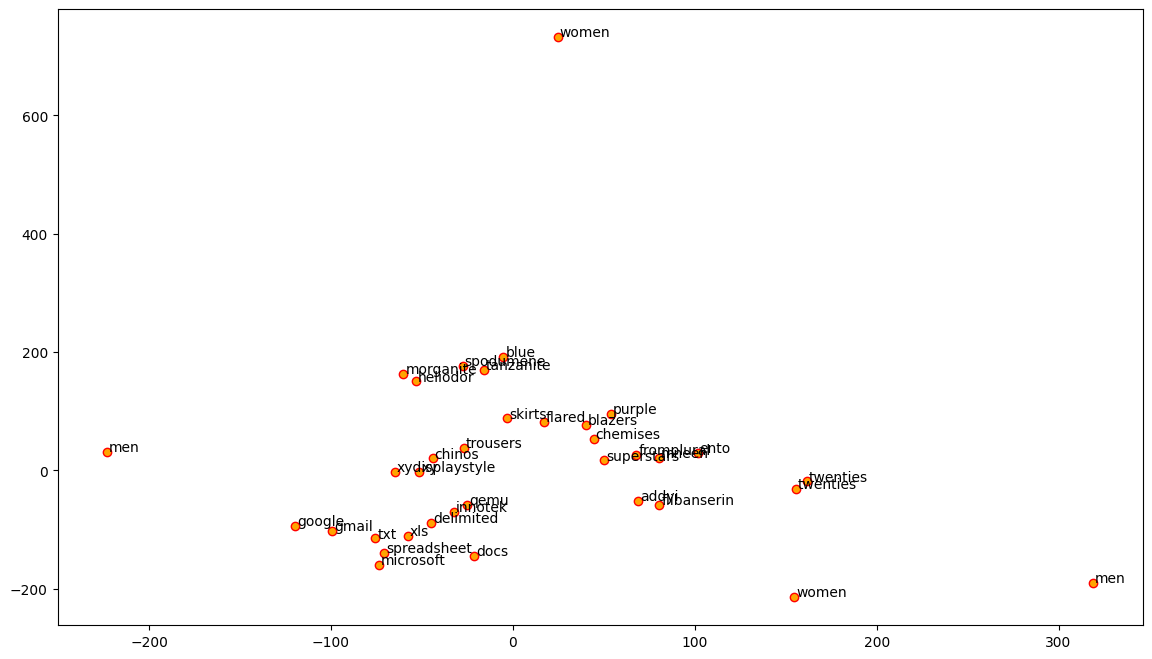

In [ ]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

In [ ]:
# Weights vector for the word "women"
(w2v_model.wv['women'])

array([ 1.0645905 , -0.89679164,  0.26800752,  1.9592347 , -0.28698123,
        0.56949395,  1.4640718 ,  0.92204815, -1.0939649 ,  1.2854036 ,
       -0.6468411 , -1.5804105 , -0.84269655,  1.092712  , -1.0808892 ,
        0.95374423,  0.8478875 ,  0.4727509 , -2.9443493 ,  0.83054554,
        1.5616658 , -3.7297454 ,  0.72486806, -0.5948035 ,  0.7094032 ,
       -2.023457  ,  1.0408933 , -0.00740387,  0.39714277, -0.641551  ,
       -0.10432313, -1.6490414 ,  1.4067032 ,  1.6993653 , -1.8466382 ,
        0.7832997 ,  1.0944661 , -0.00277686,  2.1282358 , -0.43173733,
        0.68925935,  1.081284  , -0.88195217,  1.9061409 ,  0.40306666,
        1.9459697 , -1.2008003 , -0.63345516,  0.69788796, -0.20006868,
        1.3717757 , -1.7143886 ,  1.4441882 , -1.0916907 , -2.3491673 ,
        2.3220265 , -0.37890783, -2.5778198 ,  0.38922593, -2.3688612 ,
       -0.4566366 ,  2.388896  , -0.665663  , -0.47691575, -0.07889445,
        0.35823202, -0.0054914 , -1.2921984 , -1.8815101 , -1.80

## Storing into CSV

In [ ]:
import csv

In [ ]:
lst = []
for i in range(len(text_sr.index)):
  v = np.array([0. for i in range(embedding_dim)])
  l = 0
  for word in norm_text[i].split():
    v += w2v_model.wv[word]
    l += 1
  lst.append(v / l)


In [ ]:
if wikiHow:
    wikiHow_df.to_csv(dataframe_file_path)

with open(word_vector_file_path, "w", newline="") as f:
     writer = csv.writer(f)
     writer.writerows(lst)

### Just a check

In [ ]:
dfx = pd.read_csv(word_vector_file_path, header = None)

In [ ]:
dfx.shape

(29307, 512)